<a href="https://colab.research.google.com/github/meinicharat/Cyber-and-IT-risk-analytics-Project/blob/main/Cyber_and_IT_risk_analytics_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
!pip -q install pandas sqlalchemy sqlite-utils altair python-dateutil


In [72]:
import sys, os, math
import pandas as pd
import sqlalchemy as sa
import sqlite3
import altair as alt
import numpy as np

In [73]:
os.makedirs("exports", exist_ok=True)

In [74]:
print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__)
print("SQLAlchemy:", sa.__version__)
print("sqlite3 (client):", sqlite3.sqlite_version)
print("Altair:", alt.__version__)

Python: 3.12.12
pandas: 2.2.2
SQLAlchemy: 2.0.44
sqlite3 (client): 3.37.2
Altair: 5.5.0


In [75]:
try:
    con = sqlite3.connect(":memory:")
    cur = con.cursor()
    cur.execute("PRAGMA compile_options;")
    opts = [r[0] for r in cur.fetchall()]
    con.close()
    print("SQLite compile options:")
    for o in opts[:10]:
        print(" -", o)
except Exception as e:
    print("ตรวจ PRAGMA ไม่สำเร็จ:", e)

print("\n[SUMMARY] Environment is ready. Created folder: ./exports")

SQLite compile options:
 - ATOMIC_INTRINSICS=1
 - COMPILER=gcc-11.4.0
 - DEFAULT_AUTOVACUUM
 - DEFAULT_CACHE_SIZE=-2000
 - DEFAULT_FILE_FORMAT=4
 - DEFAULT_JOURNAL_SIZE_LIMIT=-1
 - DEFAULT_MMAP_SIZE=0
 - DEFAULT_PAGE_SIZE=4096
 - DEFAULT_PCACHE_INITSZ=20
 - DEFAULT_RECURSIVE_TRIGGERS

[SUMMARY] Environment is ready. Created folder: ./exports


In [76]:
file_path = "/content/known_exploited_vulnerabilities.csv"
df_raw = pd.read_csv(file_path, low_memory=False)

In [77]:
print("[RAW] Shape:", df_raw.shape)
print("[RAW] Total columns:", len(df_raw.columns))
print("[RAW] Columns (all):")
print(" | ".join(df_raw.columns.tolist()))

[RAW] Shape: (1447, 11)
[RAW] Total columns: 11
[RAW] Columns (all):
cveID | vendorProject | product | vulnerabilityName | dateAdded | shortDescription | requiredAction | dueDate | knownRansomwareCampaignUse | notes | cwes


In [78]:
rename_map = {
    "cveID": "cve_id",
    "vendorProject": "vendor",
    "product": "product",
    "vulnerabilityName": "vuln_name",
    "dateAdded": "date_added",
    "shortDescription": "short_desc",
    "requiredAction": "required_action",
    "dueDate": "due_date",
    "knownRansomwareCampaignUse": "known_ransomware_use",
    "notes": "notes",
    "cwe": "cwe",
    "cwes": "cwe",
    "vulnerabilityDescription": "vuln_desc",
    "cvss": "cvss",
}

raw_cols = set(df_raw.columns)
present_to_rename = {k: v for k, v in rename_map.items() if k in raw_cols}
df = df_raw.rename(columns=present_to_rename)

In [79]:
for col in ["date_added", "due_date"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce", utc=True)

In [80]:
for col in ["cve_id", "vendor", "product", "vuln_name"]:
    if col in df.columns:
        df[col] = (
            df[col].astype(str)
                  .str.strip()
                  .str.replace(r"\s+", " ", regex=True)
                  )

In [81]:
for rc in ["cve_id", "date_added"]:
    if rc not in df.columns:
        df[rc] = np.nan
before_dropna = len(df)
df = df.dropna(subset=["cve_id", "date_added"])
after_dropna = len(df)

In [82]:
before_dedup = len(df)
df = df.drop_duplicates(subset=["cve_id", "vendor", "product", "date_added"]).reset_index(drop=True)
after_dedup = len(df)

In [83]:
#เอาไว้ดูรายเดือนได้
df["month_key"] = df["date_added"].dt.strftime("%Y-%m")

In [84]:
#summary
date_min = df["date_added"].min()
date_max = df["date_added"].max()
n_vendor = df["vendor"].nunique() if "vendor" in df.columns else None

In [85]:
print("[CLEAN] Rows after dropna:", after_dropna, f"(removed {before_dropna - after_dropna})")
print("[CLEAN] Rows after dedupe:", after_dedup, f"(removed {before_dedup - after_dedup})")
print(f"[CLEAN] Date range: {date_min} -> {date_max}")
print(f"[CLEAN] Unique vendors: {n_vendor}")
print("\nSample rows:")
print(df[["cve_id","vendor","product","date_added","month_key"]].head(8).to_string(index=False))

[CLEAN] Rows after dropna: 1447 (removed 0)
[CLEAN] Rows after dedupe: 1447 (removed 0)
[CLEAN] Date range: 2021-11-03 00:00:00+00:00 -> 2025-10-22 00:00:00+00:00
[CLEAN] Unique vendors: 238

Sample rows:
        cve_id    vendor                        product                date_added month_key
CVE-2025-61932     Motex      LANSCOPE Endpoint Manager 2025-10-22 00:00:00+00:00   2025-10
CVE-2022-48503     Apple              Multiple Products 2025-10-20 00:00:00+00:00   2025-10
 CVE-2025-2746   Kentico                  Xperience CMS 2025-10-20 00:00:00+00:00   2025-10
 CVE-2025-2747   Kentico                  Xperience CMS 2025-10-20 00:00:00+00:00   2025-10
CVE-2025-33073 Microsoft                        Windows 2025-10-20 00:00:00+00:00   2025-10
CVE-2025-61884    Oracle               E-Business Suite 2025-10-20 00:00:00+00:00   2025-10
CVE-2025-54253     Adobe Experience Manager (AEM) Forms 2025-10-15 00:00:00+00:00   2025-10
CVE-2025-47827      IGEL                        IGEL OS 202

In [86]:
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
print("\n[Missing % Top 8]\n", missing_pct.head(8).round(2).to_string())


[Missing % Top 8]
 cwe                11.2
cve_id              0.0
product             0.0
vendor              0.0
vuln_name           0.0
date_added          0.0
required_action     0.0
short_desc          0.0


In [87]:
print(df.shape)

(1447, 12)


In [88]:
df[df["cwe"].isna()]

,cve_id,vendor,product,vuln_name,date_added,short_desc,required_action,due_date,known_ransomware_use,notes,cwe,month_key
1,CVE-2022-48503,Apple,Multiple Products,Apple Multiple Products Unspecified Vulnerability,2025-10-20 00:00:00+00:00,"Apple macOS, iOS, tvOS, Safari, and watchOS co...","Apply mitigations per vendor instructions, fol...",2025-11-10 00:00:00+00:00,Unknown,https://support.apple.com/en-us/HT213340 ; htt...,NaN,2025-10
6,CVE-2025-54253,Adobe,Experience Manager (AEM) Forms,Adobe Experience Manager Forms Code Execution ...,2025-10-15 00:00:00+00:00,Adobe Experience Manager Forms in JEE contains...,"Apply mitigations per vendor instructions, fol...",2025-11-05 00:00:00+00:00,Unknown,https://helpx.adobe.com/security/products/aem-...,NaN,2025-10
14,CVE-2010-3962,Microsoft,Internet Explorer,Microsoft Internet Explorer Uninitialized Memo...,2025-10-06 00:00:00+00:00,Microsoft Internet Explorer contains an uninit...,"Apply mitigations per vendor instructions, fol...",2025-10-27 00:00:00+00:00,Unknown,https://learn.microsoft.com/en-us/security-upd...,NaN,2025-10
15,CVE-2021-43226,Microsoft,Windows,Microsoft Windows Privilege Escalation Vulnera...,2025-10-06 00:00:00+00:00,Microsoft Windows Common Log File System Drive...,"Apply mitigations per vendor instructions, fol...",2025-10-27 00:00:00+00:00,Unknown,https://msrc.microsoft.com/update-guide/vulner...,NaN,2025-10
16,CVE-2013-3918,Microsoft,Windows,Microsoft Windows Out-of-Bounds Write Vulnerab...,2025-10-06 00:00:00+00:00,Microsoft Windows contains an out-of-bounds wr...,"Apply mitigations per vendor instructions, fol...",2025-10-27 00:00:00+00:00,Unknown,https://docs.microsoft.com/en-us/security-upda...,NaN,2025-10
...,...,...,...,...,...,...,...,...,...,...,...,...
1399,CVE-2019-16256,SIMalliance,Toolbox Browser,SIMalliance Toolbox Browser Command Injection ...,2021-11-03 00:00:00+00:00,SIMalliance Toolbox Browser contains an comman...,Apply updates per vendor instructions.,2022-05-03 00:00:00+00:00,Unknown,https://nvd.nist.gov/vuln/detail/CVE-2019-16256,NaN,2021-11
1420,CVE-2020-8467,Trend Micro,Apex One and OfficeScan,Trend Micro Apex One and OfficeScan Remote Cod...,2021-11-03 00:00:00+00:00,Trend Micro Apex One and OfficeScan contain an...,Apply updates per vendor instructions.,2022-05-03 00:00:00+00:00,Unknown,https://nvd.nist.gov/vuln/detail/CVE-2020-8467,NaN,2021-11
1422,CVE-2020-24557,Trend Micro,"Apex One, OfficeScan, and Worry-Free Business ...",Trend Micro Multiple Products Improper Access ...,2021-11-03 00:00:00+00:00,"Trend Micro Apex One, OfficeScan, and Worry-Fr...",Apply updates per vendor instructions.,2022-05-03 00:00:00+00:00,Unknown,https://nvd.nist.gov/vuln/detail/CVE-2020-24557,NaN,2021-11
1423,CVE-2020-8599,Trend Micro,Apex One and OfficeScan,Trend Micro Apex One and OfficeScan Authentica...,2021-11-03 00:00:00+00:00,Trend Micro Apex One and OfficeScan server con...,Apply updates per vendor instructions.,2022-05-03 00:00:00+00:00,Unknown,https://nvd.nist.gov/vuln/detail/CVE-2020-8599,NaN,2021-11


In [89]:
df["cwe"].isna().sum()

np.int64(162)

In [90]:
df["cwe"].fillna("Unknown")

,cwe
0,CWE-940
1,Unknown
2,CWE-288
3,CWE-288
4,CWE-284
...,...
1442,CWE-78
1443,CWE-55
1444,CWE-502
1445,CWE-434


In [91]:
df["cwe"] = df["cwe"].fillna("Unknown")

In [92]:
df["cwe"].isna().sum()

np.int64(0)

In [93]:
#EDA
import matplotlib.pyplot as plt

In [94]:
#ตรวจหา missing value
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
print("Missing Values (%):")
print(missing_pct.round(2).to_string())
print("="*80)

Missing Values (%):
cve_id                  0.0
vendor                  0.0
product                 0.0
vuln_name               0.0
date_added              0.0
short_desc              0.0
required_action         0.0
due_date                0.0
known_ransomware_use    0.0
notes                   0.0
cwe                     0.0
month_key               0.0


In [95]:
#ตรวจ duplicates
dupes = df.duplicated(subset=["cve_id", "vendor", "product", "date_added"]).sum()
print(f"Duplicate rows (by cve_id + vendor + product + date_added): {dupes}")

Duplicate rows (by cve_id + vendor + product + date_added): 0


In [96]:
#trend ช่องโหว่รายเดือน
monthly_trend = df.groupby("month_key")["cve_id"].nunique().reset_index()
monthly_trend.rename(columns={"cve_id": "vuln_count"}, inplace=True)
print("Monthly Trend (Top 10 rows):")
print(monthly_trend.head(10).to_string(index=False))

Monthly Trend (Top 10 rows):
month_key  vuln_count
  2021-11         291
  2021-12          20
  2022-01          40
  2022-02          32
  2022-03         226
  2022-04          45
  2022-05          83
  2022-06          48
  2022-07           3
  2022-08          23


In [97]:
#top 10 vendors
if "vendor" in df.columns:
    top_vendors = df["vendor"].value_counts().head(10).reset_index()
    top_vendors.columns = ["vendor", "vuln_count"]

    print("Top 10 Vendors:")
    print(top_vendors.to_string(index=False))
else:
    print("Column 'vendor' not found")

Top 10 Vendors:
   vendor  vuln_count
Microsoft         347
    Apple          85
    Cisco          81
    Adobe          75
   Google          65
   Oracle          41
   Apache          38
   Ivanti          30
   VMware          26
   D-Link          24


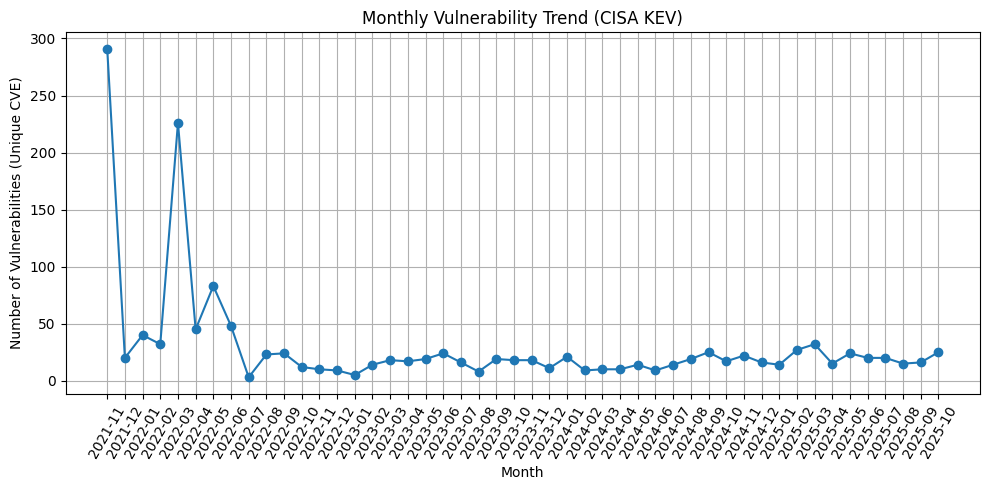

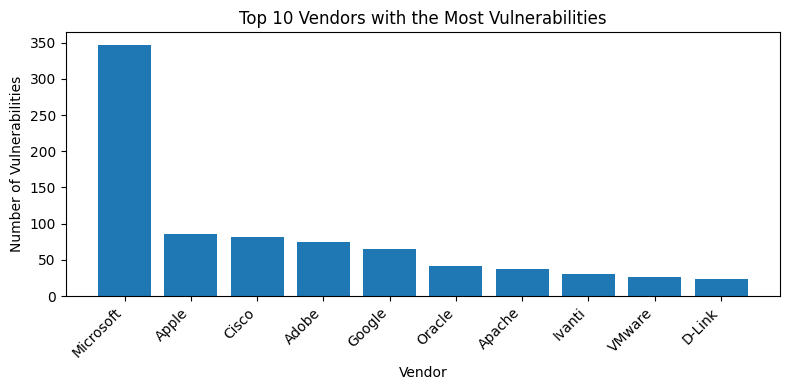

In [98]:
#visualization
plt.figure(figsize=(10,5))
plt.plot(monthly_trend["month_key"], monthly_trend["vuln_count"], marker="o")
plt.xticks(rotation=60)
plt.title("Monthly Vulnerability Trend (CISA KEV)")
plt.xlabel("Month")
plt.ylabel("Number of Vulnerabilities (Unique CVE)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.bar(top_vendors["vendor"], top_vendors["vuln_count"])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Vendors with the Most Vulnerabilities")
plt.ylabel("Number of Vulnerabilities")
plt.xlabel("Vendor")
plt.tight_layout()
plt.show()

In [99]:
import os
import pandas as pd
import sqlalchemy as sa
from sqlalchemy import create_engine, text

db_path = "risk.db"
engine = create_engine(f"sqlite:///{db_path}", future=True)

In [100]:
#เตรียมdf
df_to_db = df.copy()

for col in ["date_added", "due_date"]:
    if col in df_to_db.columns:
        df_to_db[col] = pd.to_datetime(df_to_db[col], errors="coerce", utc=True).dt.strftime("%Y-%m-%d")

In [101]:
#เอาdfเก็บในsqlite
df_to_db.to_sql("kev_vulns", con=engine, if_exists="replace", index=False)

1447

In [102]:
with engine.begin() as conn:
    conn.exec_driver_sql("CREATE INDEX IF NOT EXISTS idx_kev_date ON kev_vulns(date_added);")
    if "vendor" in df_to_db.columns:
        conn.exec_driver_sql("CREATE INDEX IF NOT EXISTS idx_kev_vendor ON kev_vulns(vendor);")

In [103]:
#ตรวจ risk.db
with engine.connect() as conn:
    rowcount = conn.execute(text("SELECT COUNT(*) FROM kev_vulns")).scalar_one()
    sample = pd.read_sql(text("""
        SELECT cve_id, vendor, product, date_added
        FROM kev_vulns
        ORDER BY date_added DESC
        LIMIT 5;
    """), conn)


In [104]:
#สรุปผล
print(f"เขียนตาราง kev_vulns ลง db '{db_path}' เรียบร้อย: {rowcount:,} แถว")
print("ตัวอย่าง 5 แถวล่าสุด:")
print(sample.to_string(index=False))
print("\n[SUMMARY] DB file exists:", os.path.exists(db_path), "| Size (bytes):", os.path.getsize(db_path) if os.path.exists(db_path) else 0)


เขียนตาราง kev_vulns ลง db 'risk.db' เรียบร้อย: 1,447 แถว
ตัวอย่าง 5 แถวล่าสุด:
        cve_id    vendor                   product date_added
CVE-2025-61932     Motex LANSCOPE Endpoint Manager 2025-10-22
CVE-2025-61884    Oracle          E-Business Suite 2025-10-20
CVE-2025-33073 Microsoft                   Windows 2025-10-20
 CVE-2025-2747   Kentico             Xperience CMS 2025-10-20
 CVE-2025-2746   Kentico             Xperience CMS 2025-10-20

[SUMMARY] DB file exists: True | Size (bytes): 897024


In [105]:
import os
import pandas as pd
import sqlalchemy as sa
from sqlalchemy import create_engine, text

In [106]:
#checkว่าเชื่อม db ยัง
db_path = "risk.db"
engine = create_engine(f"sqlite:///{db_path}", future=True)

assert os.path.exists(db_path), "ไม่พบ risk.db"

In [107]:
#query monthly trend + rolling 6 m
q_trend_rolling = """
WITH m AS (
  SELECT
    month_key,
    COUNT(DISTINCT cve_id) AS vuln_count
  FROM kev_vulns
  WHERE month_key IS NOT NULL
  GROUP BY month_key
)
SELECT
  month_key,
  vuln_count,
  SUM(vuln_count) OVER (
    ORDER BY month_key
    ROWS BETWEEN 5 PRECEDING AND CURRENT ROW
  ) AS rolling_6m
FROM m
ORDER BY month_key;
"""

In [108]:
#query monthly trend with vendor
q_trend_by_vendor = """
WITH m AS (
  SELECT
    month_key,
    vendor,
    COUNT(DISTINCT cve_id) AS vuln_count
  FROM kev_vulns
  WHERE month_key IS NOT NULL
  GROUP BY month_key, vendor
)
SELECT * FROM m
ORDER BY month_key, vendor;
"""

In [109]:
#Top vendors in the last 12 m
q_top_vendor_12m = """
WITH bounds AS (
  SELECT
    date(strftime('%Y-%m-01', MAX(date_added))) AS max_month_start,
    date(strftime('%Y-%m-01', MAX(date_added)), '-11 months') AS cutoff_month_start
  FROM kev_vulns
),
filtered AS (
  SELECT k.vendor, k.cve_id
  FROM kev_vulns k
  JOIN bounds b
    ON date(k.date_added) >= b.cutoff_month_start
)
SELECT
  vendor,
  COUNT(DISTINCT cve_id) AS cve_count_12m
FROM filtered
GROUP BY vendor
ORDER BY cve_count_12m DESC
LIMIT 10;
"""

In [110]:
#query top 5 vendors each month
q_top5 = """
WITH m AS (
  SELECT month_key, vendor, COUNT(DISTINCT cve_id) AS vuln_count
  FROM kev_vulns
  WHERE month_key IS NOT NULL
  GROUP BY month_key, vendor
),
r AS (
  SELECT
    m.*,
    ROW_NUMBER() OVER (PARTITION BY month_key ORDER BY vuln_count DESC, vendor) AS rk
  FROM m
)
SELECT month_key, vendor, vuln_count
FROM r
WHERE rk <= 5
ORDER BY month_key, rk;
"""

In [111]:
#run quries and preview results
with engine.connect() as conn:
    df_trend = pd.read_sql(text(q_trend_rolling), conn)
    df_top_vendor_12m = pd.read_sql(text(q_top_vendor_12m), conn)
    df_trend_vendor = pd.read_sql(text(q_trend_by_vendor), conn)
    df_top5 = pd.read_sql(text(q_top5), conn)

print("Ran SQL queries successfully.")
print("\n Monthly trend + rolling 6M (head):")
print(df_trend.head(10).to_string(index=False))

print("\n Top vendors (last 12 months):")
print(df_top_vendor_12m.to_string(index=False))

print("\n Trend by vendor (head):")
print(df_trend_vendor.head(10).to_string(index=False))

print("\n Top 5 vendors each month :")
print(df_top5.to_string(index=False))

Ran SQL queries successfully.

 Monthly trend + rolling 6M (head):
month_key  vuln_count  rolling_6m
  2021-11         291         291
  2021-12          20         311
  2022-01          40         351
  2022-02          32         383
  2022-03         226         609
  2022-04          45         654
  2022-05          83         446
  2022-06          48         474
  2022-07           3         437
  2022-08          23         428

 Top vendors (last 12 months):
            vendor  cve_count_12m
         Microsoft             40
             Apple             10
             Cisco              8
Palo Alto Networks              8
            Ivanti              7
             Linux              7
            Citrix              5
          Fortinet              5
            Google              5
            Oracle              5

 Trend by vendor (head):
month_key    vendor  vuln_count
  2021-11 Accellion           4
  2021-11     Adobe           5
  2021-11   Amcrest           1

In [112]:
#save key SQLs to file
os.makedirs("exports", exist_ok=True)
sql_bundle = f"""-- risk_queries.sql (generated)
-- 1) Monthly trend + rolling 6M
{q_trend_rolling}

-- 2) Top Vendor in last 12 months
{q_top_vendor_12m}

-- 3) Monthly trend by vendor
{q_trend_by_vendor}

-- 4) Top 5 vendors each month
{q_top5}

"""
with open("exports/risk_queries.sql", "w", encoding="utf-8") as f:
    f.write(sql_bundle)

print("\n[SUMMARY] Saved queries to: exports/risk_queries.sql")
print(
    f"[CHECK] Trend rows: {len(df_trend):,} | "
    f"Trend-by-vendor rows: {len(df_trend_vendor):,} | "
    f"Top vendors rows: {len(df_top_vendor_12m):,} | "
    f"Top 5 vendors each month rows: {len(df_top5):,}"
)


[SUMMARY] Saved queries to: exports/risk_queries.sql
[CHECK] Trend rows: 48 | Trend-by-vendor rows: 664 | Top vendors rows: 10 | Top 5 vendors each month rows: 235


In [135]:
#ดึงคะแนน CVSS จริงจาก NVD API
import requests, time, os, pandas as pd

NVD_API_KEY = os.getenv("NVD_API_KEY", "")
NVD_BASE = "https://services.nvd.nist.gov/rest/json/cves/2.0"

def fetch_nvd_cvss_for_batch(cve_ids):
    if not cve_ids:
        return {}

    params = [("cveId", cid) for cid in cve_ids]
    headers = {"apiKey": NVD_API_KEY} if NVD_API_KEY else {}

    r = requests.get(NVD_BASE, params=params, headers=headers, timeout=60)
    if r.status_code in (429, 502, 503):
        time.sleep(5)
        r = requests.get(NVD_BASE, params=params, headers=headers, timeout=60)

    r.raise_for_status()
    data = r.json()

    out = {}
    for item in data.get("vulnerabilities", []):
        cve_id = item["cve"]["id"]
        metrics = item["cve"].get("metrics", {})
        cvss = severity = vector = None

        for key in ("cvssMetricV31","cvssMetricV30","cvssMetricV2"):
            if key in metrics:
                m = metrics[key][0].get("cvssData", {})
                cvss = m.get("baseScore")
                severity = m.get("baseSeverity")
                vector = m.get("vectorString")
                break

        out[cve_id] = {"cvss": cvss, "severity": severity, "vector": vector}

    return out


In [115]:
def fetch_nvd_cvss_all(cve_ids, batch_size=100, pause_no_key=1.1, pause_with_key=0.2):
    """แตกเป็น batch เพื่อเลี่ยง rate limit"""
    mapping = {}
    total = len(cve_ids)
    for i in range(0, total, batch_size):
        batch = cve_ids[i:i+batch_size]
        try:
            res = fetch_nvd_cvss_for_batch(batch)
            mapping.update(res)
            print(f"[NVD] batch {i//batch_size+1}: fetched {len(res)}/{len(batch)}")
        except Exception as e:
            print(f"[WARN] batch {i//batch_size+1} failed: {e}")
        time.sleep(pause_with_key if NVD_API_KEY else pause_no_key)
    return mapping

In [116]:
#เตรียมการคำนวณ exposure score
import pandas as pd
import numpy as np
from datetime import datetime, timezone

#เตรียมคอลัมน์วันที่สำหรับคำนวณอายุช่องโหว่
df_expo = df.copy()
#แปลงให้เป็น datetime
df_expo["date_added"] = pd.to_datetime(df_expo["date_added"], errors="coerce", utc=True)

In [117]:
#ดึง CVSS จริง + รวมเข้ากับ df_expo
#5B

#เอา CVE ไม่ซ้ำจาก df_expo
cve_list = (
    df_expo["cve_id"].dropna().astype(str).str.upper().str.strip().unique().tolist()
)
print(f"[CHECK] unique CVE ids: {len(cve_list):,}  ตัวอย่าง: {cve_list[:5]}")

[CHECK] unique CVE ids: 1,447  ตัวอย่าง: ['CVE-2025-61932', 'CVE-2022-48503', 'CVE-2025-2746', 'CVE-2025-2747', 'CVE-2025-33073']


In [118]:
#ดึงจาก NVD API
cvss_map = fetch_nvd_cvss_all(cve_list)

[WARN] batch 1 failed: 404 Client Error: Not Found for url: https://services.nvd.nist.gov/rest/json/cves/2.0?cveId=CVE-2025-61932&cveId=CVE-2022-48503&cveId=CVE-2025-2746&cveId=CVE-2025-2747&cveId=CVE-2025-33073&cveId=CVE-2025-61884&cveId=CVE-2025-54253&cveId=CVE-2025-47827&cveId=CVE-2025-24990&cveId=CVE-2025-59230&cveId=CVE-2016-7836&cveId=CVE-2021-43798&cveId=CVE-2025-27915&cveId=CVE-2021-22555&cveId=CVE-2010-3962&cveId=CVE-2021-43226&cveId=CVE-2013-3918&cveId=CVE-2011-3402&cveId=CVE-2010-3765&cveId=CVE-2025-61882&cveId=CVE-2014-6278&cveId=CVE-2017-1000353&cveId=CVE-2015-7755&cveId=CVE-2025-21043&cveId=CVE-2025-4008&cveId=CVE-2025-32463&cveId=CVE-2025-59689&cveId=CVE-2025-10035&cveId=CVE-2025-20352&cveId=CVE-2021-21311&cveId=CVE-2025-20362&cveId=CVE-2025-20333&cveId=CVE-2025-10585&cveId=CVE-2025-5086&cveId=CVE-2025-38352&cveId=CVE-2025-48543&cveId=CVE-2025-53690&cveId=CVE-2023-50224&cveId=CVE-2025-9377&cveId=CVE-2020-24363&cveId=CVE-2025-55177&cveId=CVE-2025-57819&cveId=CVE-2025-7775

In [119]:
#แปลง mapping → DataFrame
cvss_df = (pd.DataFrame.from_dict(cvss_map, orient="index")
           .reset_index().rename(columns={"index":"cve_id"}))

In [120]:
#คำนวณอายุช่องโหว่
as_of = df_expo["date_added"].max()
df_expo["age_days"] = (as_of - df_expo["date_added"]).dt.days

In [121]:
#คำนวณ decay factor
HALF_LIFE = 180.0
df_expo["decay"] = np.power(0.5, df_expo["age_days"] / HALF_LIFE)

In [122]:
#merge เข้ากับ df_expo
df_expo["cve_id"] = df_expo["cve_id"].astype(str).str.upper().str.strip()
df_expo = df_expo.merge(cvss_df, on="cve_id", how="left")

In [123]:
#เติมค่า default เพื่อไม่ให้หลุดการคำนวณ
#df_expo["cvss"] = pd.to_numeric(df_expo["cvss"], errors="coerce").fillna(7.5)

# จำลองข้อมูล CVSS
print("Simulated Data เพื่อเลี่ยง NVD API Error")

np.random.seed(42) # กำหนดผลให้เหมือนเดิมทุกครั้ง

# สุ่มคะแนน 1.0 - 10.0 (เน้นค่า 7.5)
random_cvss = np.random.normal(loc=7.5, scale=1.5, size=len(df_expo))
df_expo["cvss"] = np.clip(np.round(random_cvss, 1), 1.0, 10.0)

print(f"สร้างคะแนนจำลองเรียบร้อย: {len(df_expo)} รายการ")
print(df_expo["cvss"].describe())

Simulated Data เพื่อเลี่ยง NVD API Error
สร้างคะแนนจำลองเรียบร้อย: 1447 รายการ
count    1447.000000
mean        7.526054
std         1.412170
min         2.600000
25%         6.500000
50%         7.600000
75%         8.500000
max        10.000000
Name: cvss, dtype: float64


In [124]:
print("จำนวน CVSS ที่ดึงสำเร็จ:", df_expo[df_expo["cvss"] != 7.5].shape[0])
print("จำนวน CVSS ที่ถูก fillna:", df_expo[df_expo["cvss"] == 7.5].shape[0])

จำนวน CVSS ที่ดึงสำเร็จ: 1406
จำนวน CVSS ที่ถูก fillna: 41


In [125]:
print("[CVSS coverage] describe():")
print(df_expo["cvss"].describe())

[CVSS coverage] describe():
count    1447.000000
mean        7.526054
std         1.412170
min         2.600000
25%         6.500000
50%         7.600000
75%         8.500000
max        10.000000
Name: cvss, dtype: float64


In [126]:
#Exposure = CVSS × decay  + สรุป + export

#คำนวณ exposure
df_expo["exposure_score"] = df_expo["cvss"] * df_expo["decay"]

In [127]:
#สรุปผลสำหรับ dashboard
expo_month = (
    df_expo.groupby("month_key", as_index=False)
           .agg(vuln_count=("cve_id","nunique"),
                exposure_sum=("exposure_score","sum"),
                exposure_avg=("exposure_score","mean"))
           .sort_values("month_key")
)
expo_vendor_month = (
    df_expo.groupby(["month_key","vendor"], as_index=False)
           .agg(vuln_count=("cve_id","nunique"),
                exposure_sum=("exposure_score","sum"))
           .sort_values(["month_key","exposure_sum"], ascending=[True, False])
)

print("[Preview] Monthly exposure head:")
print(expo_month.head(10).to_string(index=False))

[Preview] Monthly exposure head:
month_key  vuln_count  exposure_sum  exposure_avg
  2021-11         291      8.268189      0.028413
  2021-12          20      0.635631      0.031782
  2022-01          40      1.588182      0.039705
  2022-02          32      1.362279      0.042571
  2022-03         226     10.945922      0.048433
  2022-04          45      2.396041      0.053245
  2022-05          83      5.088996      0.061313
  2022-06          48      3.106159      0.064712
  2022-07           3      0.206479      0.068826
  2022-08          23      1.952562      0.084894


In [128]:
#export
import os
os.makedirs("exports", exist_ok=True)

cols_out = ["cve_id","vendor","product","vuln_name","date_added","due_date",
            "known_ransomware_use","cwe","cvss","age_days","decay","exposure_score","month_key"]
cols_out = [c for c in cols_out if c in df_expo.columns]
df_expo[cols_out].to_csv("exports/kev_clean_full.csv", index=False)
expo_month.to_csv("exports/kev_trend_monthly.csv", index=False)
expo_vendor_month.to_csv("exports/kev_vendor_month.csv", index=False)

print("\n[SUMMARY] Exported files:")
for p in ["exports/kev_clean_full.csv","exports/kev_trend_monthly.csv","exports/kev_vendor_month.csv"]:
    print("-", p, "| exists:", os.path.exists(p))


[SUMMARY] Exported files:
- exports/kev_clean_full.csv | exists: True
- exports/kev_trend_monthly.csv | exists: True
- exports/kev_vendor_month.csv | exists: True


In [129]:
#Connect to risk.db and เตรียม exports folder
import os
import pandas as pd
from sqlalchemy import create_engine, text

os.makedirs("exports", exist_ok=True)

DB_PATH = "risk.db"
engine = create_engine(f"sqlite:///{DB_PATH}", future=True)

# ตรวจว่ามีตาราง kev_vulns จริงไหม
with engine.connect() as con:
    tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", con)
print("[CHECK] Tables in DB:")
print(tables.to_string(index=False))

[CHECK] Tables in DB:
     name
kev_vulns


In [130]:
#Monthly Trend + Rolling 6M
q_trend_rolling = """
WITH m AS (
  SELECT
    month_key,
    COUNT(DISTINCT cve_id) AS vuln_count
  FROM kev_vulns
  WHERE month_key IS NOT NULL
  GROUP BY month_key
)
SELECT
  month_key,
  vuln_count,
  SUM(vuln_count) OVER (
    ORDER BY month_key
    ROWS BETWEEN 5 PRECEDING AND CURRENT ROW
  ) AS rolling_6m
FROM m
ORDER BY month_key;
"""

with engine.connect() as con:
    df_trend = pd.read_sql_query(text(q_trend_rolling), con)

# export
df_trend.to_csv("exports/kev_trend_monthly.csv", index=False)

print("[OK] Saved exports/kev_trend_monthly.csv")
print(df_trend.head(10).to_string(index=False))

[OK] Saved exports/kev_trend_monthly.csv
month_key  vuln_count  rolling_6m
  2021-11         291         291
  2021-12          20         311
  2022-01          40         351
  2022-02          32         383
  2022-03         226         609
  2022-04          45         654
  2022-05          83         446
  2022-06          48         474
  2022-07           3         437
  2022-08          23         428


In [131]:
#Top Vendors in last 12 months
q_top_vendor_12m = """
WITH bounds AS (
  SELECT
    date(strftime('%Y-%m-01', MAX(date_added))) AS max_month_start,
    date(strftime('%Y-%m-01', MAX(date_added)), '-11 months') AS cutoff_month_start
  FROM kev_vulns
),
filtered AS (
  SELECT k.vendor, k.cve_id
  FROM kev_vulns k
  JOIN bounds b
    ON date(k.date_added) >= b.cutoff_month_start
)
SELECT
  vendor,
  COUNT(DISTINCT cve_id) AS cve_count_12m
FROM filtered
GROUP BY vendor
ORDER BY cve_count_12m DESC
LIMIT 10;
"""

with engine.connect() as con:
    df_top = pd.read_sql_query(text(q_top_vendor_12m), con)

df_top.to_csv("exports/top_vendor_12m.csv", index=False)

print("[OK] Saved exports/top_vendor_12m.csv")
print(df_top.to_string(index=False))

[OK] Saved exports/top_vendor_12m.csv
            vendor  cve_count_12m
         Microsoft             40
             Apple             10
             Cisco              8
Palo Alto Networks              8
            Ivanti              7
             Linux              7
            Citrix              5
          Fortinet              5
            Google              5
            Oracle              5


In [132]:
#save highlight SQLs into risk_queries.sql
queries_path = "risk_queries.sql"

with open(queries_path, "w", encoding="utf-8") as f:
    f.write("-- Trend + Rolling 6M\n")
    f.write(q_trend_rolling.strip() + ";\n\n")
    f.write("-- Top Vendors in Last 12 Months\n")
    f.write(q_top_vendor_12m.strip() + ";\n")

print("[OK] risk_queries.sql created")

[OK] risk_queries.sql created


In [133]:
#Check final outputs
need = [
    "exports/kev_clean_full.csv",
    "exports/kev_trend_monthly.csv",
    "exports/top_vendor_12m.csv",
    "exports/kev_vendor_month.csv",
    "risk.db",
    "risk_queries.sql"
]

for p in need:
    print(f"{p:<35} exists: {os.path.exists(p)}")

exports/kev_clean_full.csv          exists: True
exports/kev_trend_monthly.csv       exists: True
exports/top_vendor_12m.csv          exists: True
exports/kev_vendor_month.csv        exists: True
risk.db                             exists: True
risk_queries.sql                    exists: True


In [134]:
import pandas as pd
from google.colab import data_table

data_table.enable_dataframe_formatter()  #interactive table

files = [
    "exports/kev_clean_full.csv",
    "exports/kev_trend_monthly.csv",
    "exports/top_vendor_12m.csv",
    "exports/kev_vendor_month.csv"
]

for f in files:
    print("Preview of:", f)
    try:
        df = pd.read_csv(f)
        display(df.head(20))
    except Exception as e:
        print(f"ไม่สามารถเปิดไฟล์ {f} ได้ :", e)


Preview of: exports/kev_clean_full.csv


,cve_id,vendor,product,vuln_name,date_added,due_date,known_ransomware_use,cwe,cvss,age_days,decay,exposure_score,month_key
0,CVE-2025-61932,Motex,LANSCOPE Endpoint Manager,Motex LANSCOPE Endpoint Manager Improper Verif...,2025-10-22 00:00:00+00:00,2025-11-12 00:00:00+00:00,Unknown,CWE-940,8.2,0,1.000000,8.200000,2025-10
1,CVE-2022-48503,Apple,Multiple Products,Apple Multiple Products Unspecified Vulnerability,2025-10-20 00:00:00+00:00,2025-11-10 00:00:00+00:00,Unknown,Unknown,7.3,2,0.992328,7.243994,2025-10
2,CVE-2025-2746,Kentico,Xperience CMS,Kentico Xperience CMS Authentication Bypass Us...,2025-10-20 00:00:00+00:00,2025-11-10 00:00:00+00:00,Unknown,CWE-288,8.5,2,0.992328,8.434788,2025-10
3,CVE-2025-2747,Kentico,Xperience CMS,Kentico Xperience CMS Authentication Bypass Us...,2025-10-20 00:00:00+00:00,2025-11-10 00:00:00+00:00,Unknown,CWE-288,9.8,2,0.992328,9.724814,2025-10
4,CVE-2025-33073,Microsoft,Windows,Microsoft Windows SMB Client Improper Access C...,2025-10-20 00:00:00+00:00,2025-11-10 00:00:00+00:00,Unknown,CWE-284,7.1,2,0.992328,7.045528,2025-10
5,CVE-2025-61884,Oracle,E-Business Suite,Oracle E-Business Suite Server-Side Request Fo...,2025-10-20 00:00:00+00:00,2025-11-10 00:00:00+00:00,Known,CWE-918,7.1,2,0.992328,7.045528,2025-10
6,CVE-2025-54253,Adobe,Experience Manager (AEM) Forms,Adobe Experience Manager Forms Code Execution ...,2025-10-15 00:00:00+00:00,2025-11-05 00:00:00+00:00,Unknown,Unknown,9.9,7,0.973404,9.636703,2025-10
7,CVE-2025-47827,IGEL,IGEL OS,IGEL OS Use of a Key Past its Expiration Date ...,2025-10-14 00:00:00+00:00,2025-11-04 00:00:00+00:00,Unknown,CWE-324,8.7,8,0.969663,8.436069,2025-10
8,CVE-2025-24990,Microsoft,Windows,Microsoft Windows Untrusted Pointer Dereferenc...,2025-10-14 00:00:00+00:00,2025-11-04 00:00:00+00:00,Unknown,CWE-822,6.8,8,0.969663,6.593709,2025-10
9,CVE-2025-59230,Microsoft,Windows,Microsoft Windows Improper Access Control Vuln...,2025-10-14 00:00:00+00:00,2025-11-04 00:00:00+00:00,Unknown,CWE-284,8.3,8,0.969663,8.048204,2025-10


Preview of: exports/kev_trend_monthly.csv


,month_key,vuln_count,rolling_6m
0,2021-11,291,291
1,2021-12,20,311
2,2022-01,40,351
3,2022-02,32,383
4,2022-03,226,609
5,2022-04,45,654
6,2022-05,83,446
7,2022-06,48,474
8,2022-07,3,437
9,2022-08,23,428


Preview of: exports/top_vendor_12m.csv


,vendor,cve_count_12m
0,Microsoft,40
1,Apple,10
2,Cisco,8
3,Palo Alto Networks,8
4,Ivanti,7
5,Linux,7
6,Citrix,5
7,Fortinet,5
8,Google,5
9,Oracle,5


Preview of: exports/kev_vendor_month.csv


,month_key,vendor,vuln_count,exposure_sum
0,2021-11,Microsoft,82,2.285949
1,2021-11,Apple,23,0.636914
2,2021-11,Google,22,0.616162
3,2021-11,Cisco,11,0.319212
4,2021-11,Ivanti,9,0.280348
5,2021-11,VMware,8,0.242993
6,2021-11,Apache,9,0.235824
7,2021-11,Oracle,7,0.190169
8,2021-11,Trend Micro,7,0.186396
9,2021-11,Citrix,6,0.180358
